# <div align=center> Améliorez le produit IA de votre start-up  </div>

## Traitement et analyse des commentaires

### Wordcloud

LDA Topics:


C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\aurel\anaconda3\envs\env_P6\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.color

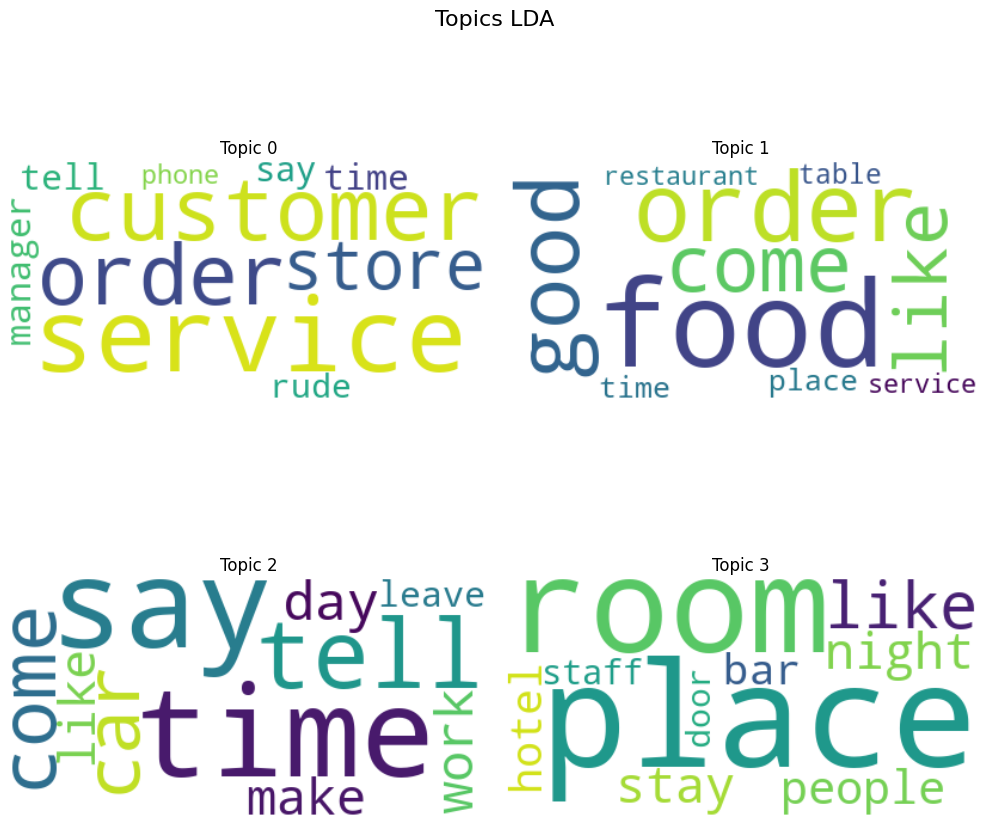

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import random
import nltk
import json
import csv
import os
import random
import cv2
import seaborn as sns
import re
import matplotlib.pyplot as plt
from nltk import pos_tag
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

num_topics = 4

def topic_modeling_lda(reviews, num_topics=num_topics):
    """
    Vectorise le corpus en utilisant CountVectorizer et crée le modèle LDA. Retourne le modèle, le vectorizer, les vecteurs de
    sujet pour chaque document et la matrice de comptage.

    Args:
        reviews (list of str): Liste des revues à analyser.
        num_topics (int): Nombre de sujets à générer avec le modèle LDA.

    Returns:
        tuple: Quadruplet contenant le modèle LDA, le vectorizer, les vecteurs de sujet et la matrice de comptage.
    """
    vectorizer = CountVectorizer(
        max_df=0.95, min_df=3, max_features=1000, stop_words="english"
    )
    count_matrix = vectorizer.fit_transform(reviews)
    lda_model = LatentDirichletAllocation(
        n_components=num_topics, learning_method="online", random_state=0
    )
    lda_model.fit(count_matrix)
    topic_vectors = lda_model.transform(count_matrix)
    return lda_model, vectorizer, topic_vectors, count_matrix


negative_reviews = pd.read_pickle("sample_text_data.pkl")
preprocessed_reviews = [review for review in negative_reviews.cleaned_text.values]
lda_model, count_vectorizer, topic_vectors, dtm = topic_modeling_lda(
    preprocessed_reviews, num_topics=4
)
lda_features_names = count_vectorizer.get_feature_names_out()

def plot_wordcloud(lda_model, lda_features_names, num_topics=4):
    """
    Affiche une visualisation de nuage de mots pour chaque sujet d'un modèle LDA.
    Chaque nuage de mots est basé sur les 10 mots les plus importants de chaque sujet.

    Args:
        lda_model (LatentDirichletAllocation): Modèle LDA.
        lda_features_names (list of str): Liste des mots de fonctionnalité utilisés par le vectorizer.
        num_topics (int, optional): Nombre de sujets à visualiser. Par défaut à 4.

    Returns:
        None. Cette fonction affiche directement les nuages de mots.
    """
    fig, axes = plt.subplots(int(num_topics / 2), 2, figsize=(10, 10))

    for i in range(num_topics):
        topic_words = lda_model.components_[i]
        top_word_indices = topic_words.argsort()[:-11:-1]
        wc_dict = {
            lda_features_names[index]: topic_words[index] for index in top_word_indices
        }
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(wc_dict)
        ax = axes[i // 2, i % 2]
        ax.set_title(f"Topic {i}")
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
    plt.tight_layout()
    plt.suptitle("Topics LDA", fontsize=16)
    plt.show()


def plot_tsne(topic_vectors, num_topics=4):
    """
    Affiche une visualisation t-SNE (t-Distributed Stochastic Neighbor Embedding) des sujets d'un modèle LDA.
    Chaque point dans la visualisation représente un document, coloré en fonction de son sujet dominant.

    Args:
        topic_vectors (array-like): Vecteurs de sujet pour chaque document.
                                    C'est la sortie de la méthode 'transform' d'un modèle LDA.
        num_topics (int, optional): Nombre de sujets à visualiser. Par défaut à 4.

    Returns:
        numpy.ndarray: Tableau indiquant le sujet dominant pour chaque document.
    """
    dominant_topics = np.argmax(topic_vectors, axis=1)
    colors = np.array(
        [plt.cm.tab10(i / float(num_topics - 1)) for i in range(num_topics)]
    )
    tsne_model = TSNE(n_components=2, random_state=0)
    tsne_vectors = tsne_model.fit_transform(topic_vectors)
    plt.figure(figsize=(8, 8))
    for i in range(num_topics):
        plt.scatter(
            tsne_vectors[dominant_topics == i, 0],
            tsne_vectors[dominant_topics == i, 1],
            color=colors[i],
            label=f"Topic {i}",
            alpha=0.5,
        )
    plt.legend()
    plt.title("Visualisation t-SNE des sujets de modélisation LDA")
    plt.show()
    return dominant_topics

plot_wordcloud(lda_model, lda_features_names)

### t-SNE

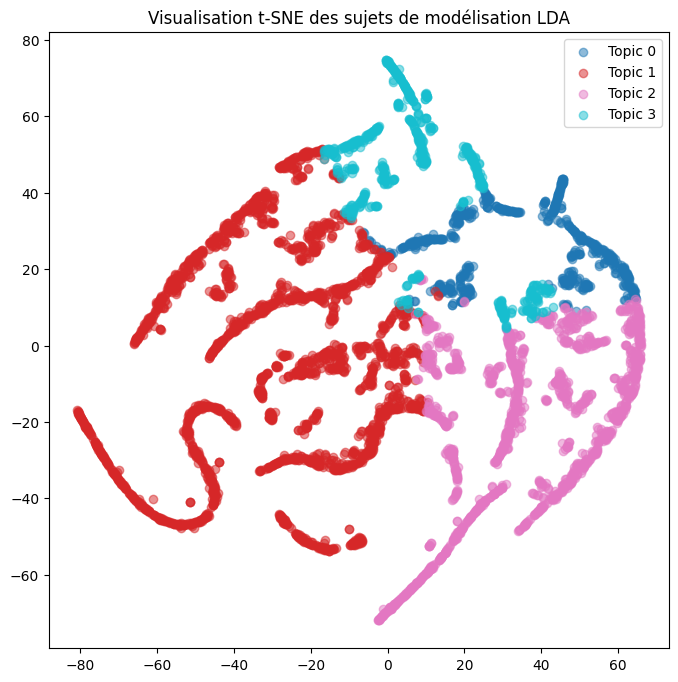

In [2]:
dominant_topics = plot_tsne(topic_vectors)

### LDAVis

In [3]:
pyLDAvis.lda_model.prepare(lda_model, dtm, count_vectorizer, mds="mmds")

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.150015 -0.110335       1        1  40.141835
2     -0.083866  0.106682       2        1  30.553973
3      0.103510 -0.159521       3        1  14.818708
0      0.130371  0.163174       4        1  14.485484, topic_info=           Term         Freq        Total Category  logprob  loglift
355        food  2988.000000  2988.000000  Default  30.0000  30.0000
605       order  2515.000000  2515.000000  Default  29.0000  29.0000
783     service  2180.000000  2180.000000  Default  28.0000  28.0000
220    customer   792.000000   792.000000  Default  27.0000  27.0000
741        room   617.000000   617.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
479        know   176.332021   993.525436   Topic4  -4.9174   0.2031
315  experience   167.063602   910.674522   Topic4  -4.9714   0.2362
578        need   150.456521   607.549716   Topic4  -5.0761   0.5363
965         way   152.060565   792.084015   Topic4  -5.0655   0.2816
924         try   150.852898  1117.706474   Topic4  -5.0735  -0.0707

[282 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         2  0.982536   accept
5         2  0.981139  account
16        3  0.108466   advise
16        4  0.867728   advise
22        3  0.991926  airport
...     ...       ...      ...
992       4  0.452273    wrong
994       1  0.099680     year
994       2  0.859148     year
994       3  0.028480     year
994       4  0.018987     year

[499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

## Traitement et analyse des images

Text(0.5, 0.98, "Echantillon d'images et de leurs labels")

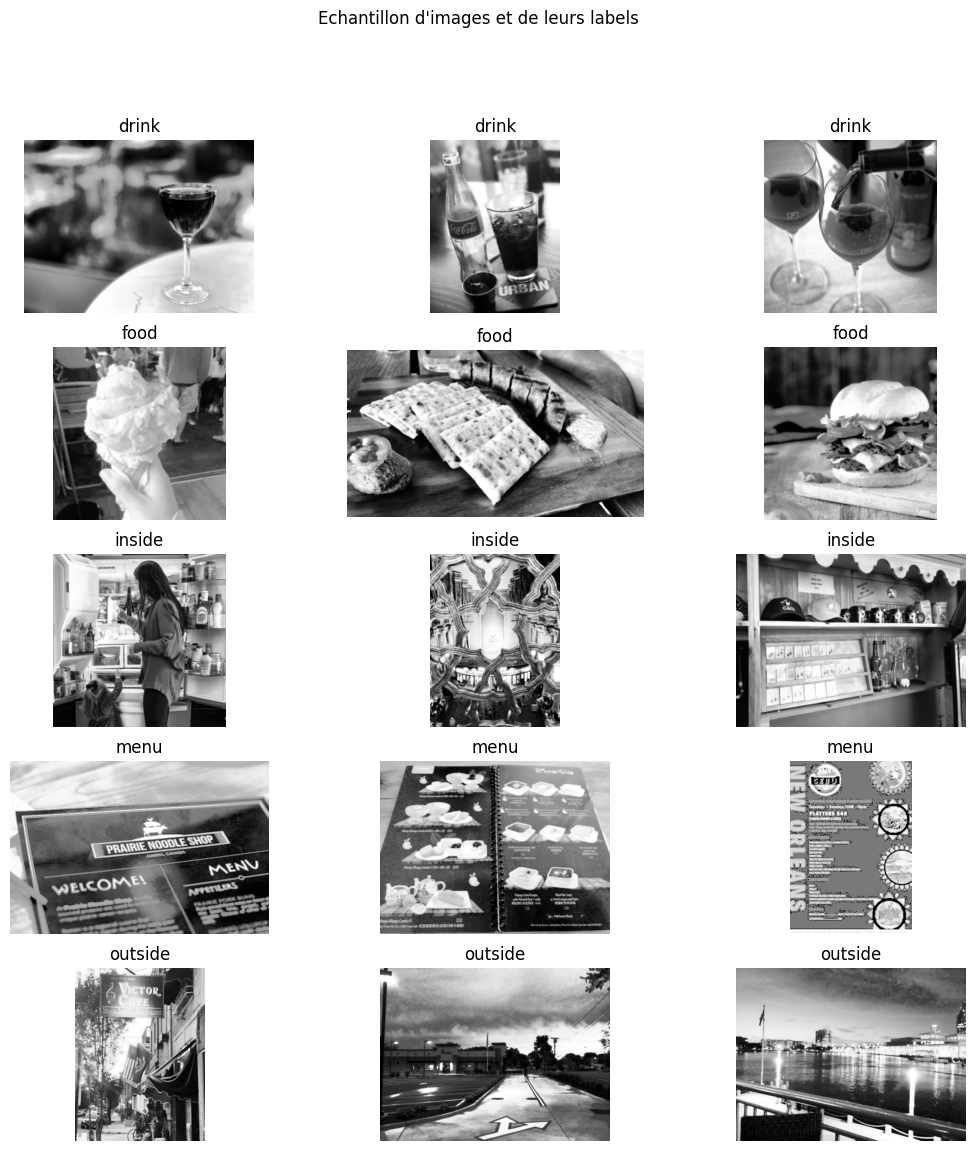

In [4]:
def preprocess_image(image_path):
    """
    Prétraite une image : charge l'image en niveau de gris, applique un filtre Gaussien, égalise l'histogramme.

    Args:
        image_path (str): Chemin vers l'image à prétraiter.

    Returns:
        numpy.ndarray: Image prétraitée. None si l'image n'a pas pu être chargée.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"L'image n'a pas pu être chargée. Chemin d'accès : {image_path}")
        return None
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    return img


def get_images(df, input_dir):
    """
    Charge et pré-traite les images à partir d'un DataFrame et d'un répertoire d'entrée.
    Ne conserve que les images valides (jusqu'à 200 par label).

    Args:
        df (pandas.DataFrame): DataFrame contenant les identifiants et labels des images.
        input_dir (str): Répertoire contenant les images.

    Returns:
        list: Liste d'images prétraitées.
        list: Liste de labels correspondants.
    """ 

    images = []
    labels = []

    
    valid_images_per_label = {}

    for index, row in df.iterrows():
        image_id = row["photo_id"]
        label = row["label"]

        if valid_images_per_label.get(label, 0) >= 200:
            continue

        image_path = os.path.join(input_dir, f"{image_id}.jpg")
        img = preprocess_image(image_path)
        if img is not None:
            images.append(img)
            labels.append(label)
            valid_images_per_label[label] = valid_images_per_label.get(label, 0) + 1

    return images, labels


input_dir = "data/photos"
df_sampled = pd.read_pickle("sample_image_data.pkl")
images, labels = get_images(df_sampled, input_dir)


def show_image_label(image, label):
    plt.imshow(image, "gray")
    plt.axis("off")
    plt.title(label)


# Liste des indices des images à afficher
img_indices = [0, 1, 2, 201, 202, 203, 401, 402, 403, 601, 602, 603, 801, 802, 803]
plt.figure(figsize=(13, 13))
for i in range(15):
    plt.subplot(5, 3, i + 1)
    show_image_label(images[img_indices[i]], labels[img_indices[i]])
plt.suptitle("Echantillon d'images et de leurs labels")

### SIFT

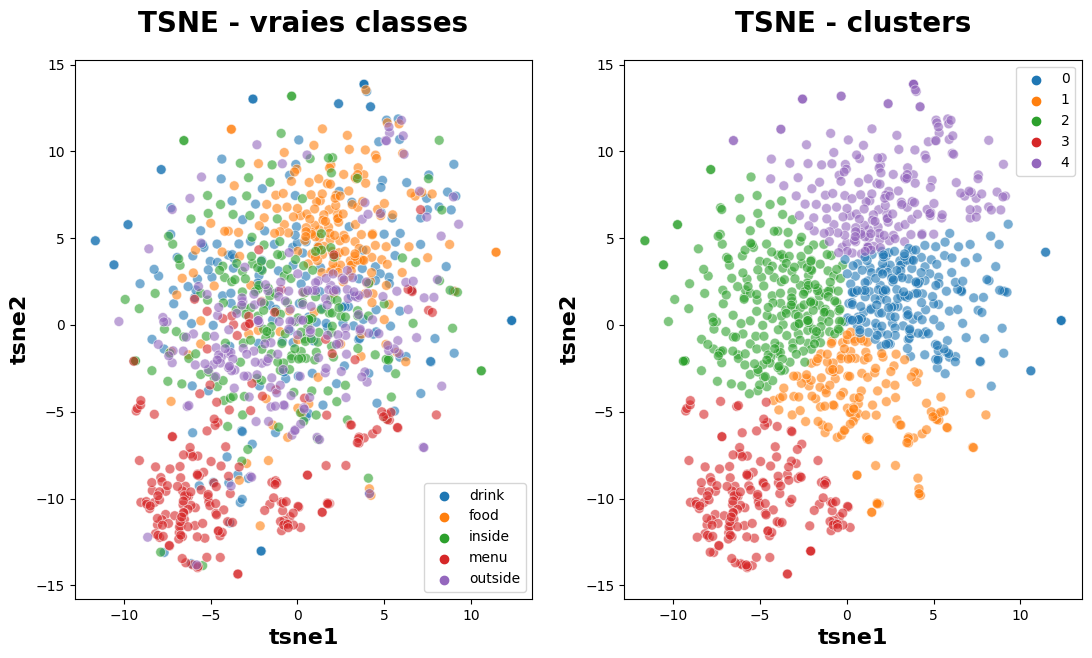

ARI :  0.15941096638122362


In [5]:
def extract_features_sift(img):
    """
    Extrait les descripteurs de caractéristiques SIFT d'une image.

    Args:
        img (numpy.ndarray): L'image à partir de laquelle les caractéristiques doivent être extraites.

    Returns:
        des (numpy.ndarray): Le descripteur SIFT pour l'image.
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)

    return des


# Extraire les caractéristiques de toutes les images
sift_keypoints = []
for img in images:
    sift_keypoints.append(extract_features_sift(img))
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
k = int(round(np.sqrt(len(sift_keypoints_all))))
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)


def build_histogram(kmeans, des, image_num):
    """
    Construit un histogramme des descripteurs SIFT en utilisant le clustering k-means.

    Args:
        kmeans (sklearn.cluster.KMeans): Le modèle k-means utilisé pour le clustering.
        des (numpy.ndarray): Le descripteur SIFT de l'image.
        image_num (int): Le numéro de l'image (utilisé pour l'itération des images').

    Returns:
        hist (numpy.ndarray): L'histogramme des descripteurs SIFT.
    """
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problèmes histogramme image")
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector
im_features = np.asarray(hist_vectors)

pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(im_features)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels

cls = KMeans(n_clusters=5, random_state=0)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_

palette = sns.color_palette("tab10", n_colors=5)
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE - vraies classes", fontsize=20, pad=20, fontweight="bold")
plt.xlabel("tsne1", fontsize=16, fontweight="bold")
plt.ylabel("tsne2", fontsize=16, fontweight="bold")
plt.legend(prop={"size": 10})

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="cluster",
    palette=palette,
    data=df_tsne,
    legend="brief",
    s=50,
    alpha=0.6,
)

plt.title("TSNE - clusters", fontsize=20, pad=20, fontweight="bold")
plt.xlabel("tsne1", fontsize=16, fontweight="bold")
plt.ylabel("tsne2", fontsize=16, fontweight="bold")
plt.legend(prop={"size": 10})

plt.show()

print("ARI : ", adjusted_rand_score(labels, cls.labels_))

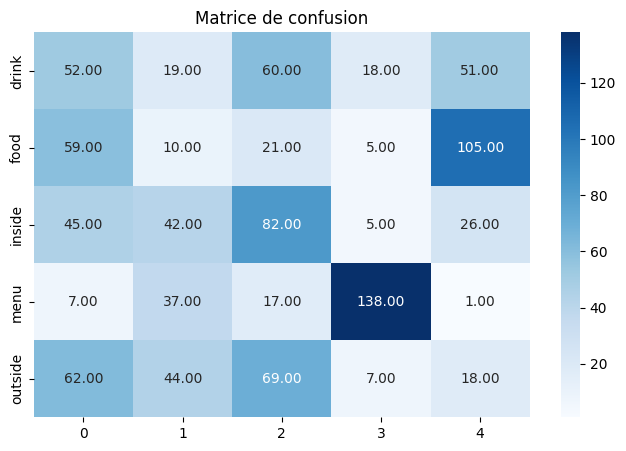

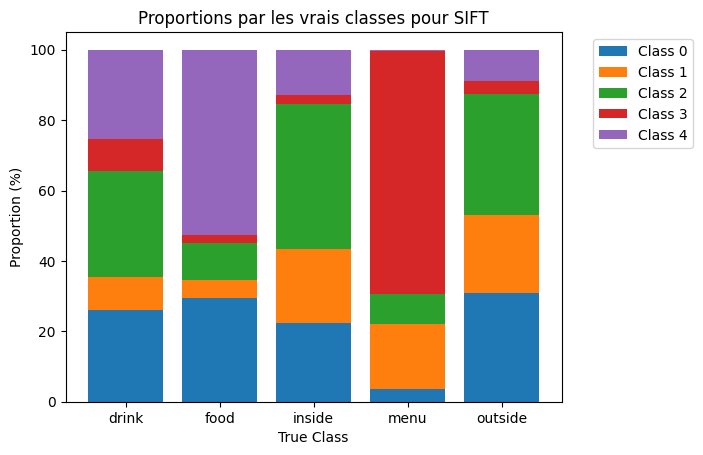

In [9]:
def confusion(y_test, y_pred):
    """
    Génère une matrice de confusion sous forme de DataFrame Pandas.

    Args:
        y_test (list or np.array): Les valeurs réelles de y.
        y_pred (list or np.array): Les valeurs prédites de y.

    Returns:
        mat (pd.DataFrame): La matrice de confusion.
    """
    list_labels = ["drink", "food", "inside", "menu", "outside"]
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [i for i in mat.columns]
    mat.index = [i for i in list_labels]
    return mat


labels_encoded = LabelEncoder().fit_transform(labels)
conf_mat_sift = confusion(labels_encoded, cls.labels_)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_mat_sift, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")


def plot_stacked_bar(df, title):
    """
    Trace un diagramme à barres empilées à partir d'un DataFrame pour visualiser les proportions de classes prédites pour chaque
    classe réelle dans un problème de classification.

    Args:
        df (DataFrame): DataFrame à partir duquel le graphique est tracé.
                        Les lignes correspondent aux classes réelles et les colonnes aux classes prédites.
        title (str)   : Titre du graphique.
    """
    df = df.div(df.sum(axis=1), axis=0) * 100
    labels = df.index
    num_labels = len(labels)

    x = np.arange(num_labels)  # Les labels sur l'axe x

    # Pour SIFT
    fig, ax = plt.subplots()

    for i in range(df.shape[1]):
        if i == 0:
            ax.bar(x, df.iloc[:, i], label="Class " + str(i))
        else:
            ax.bar(
                x,
                df.iloc[:, i],
                bottom=df.iloc[:, :i].sum(axis=1),
                label="Class " + str(i),
            )

    ax.set_xlabel("True Class")
    ax.set_ylabel("Proportion (%)")
    ax.set_title(f"Proportions par les vrais classes pour {title}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plot_stacked_bar(conf_mat_sift, "SIFT")

### VGG-16

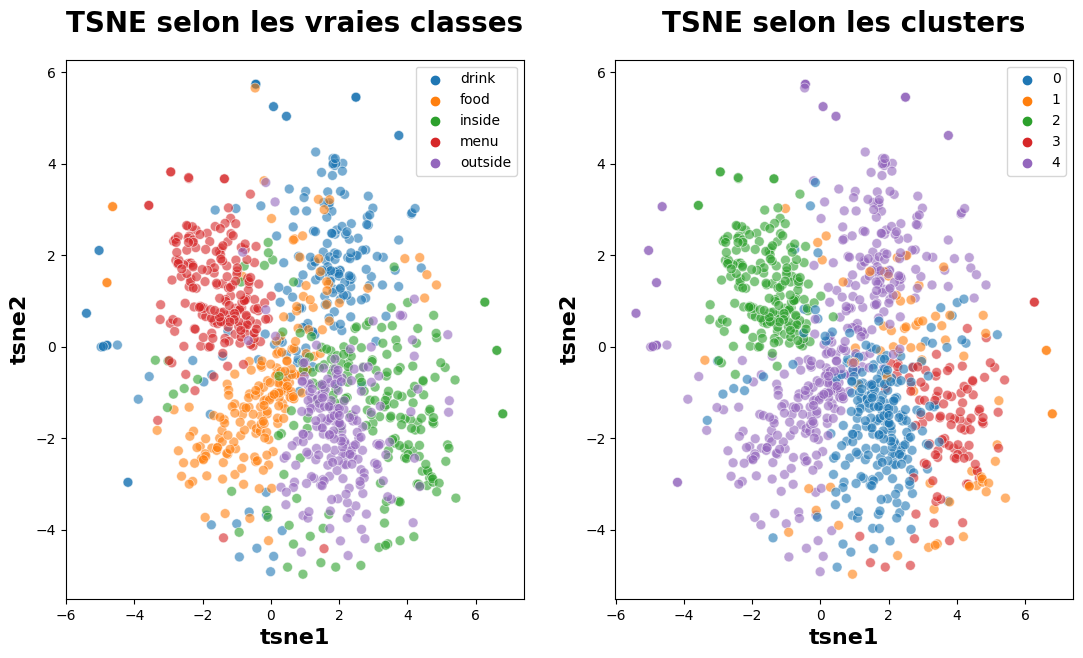

ARI :  0.5153675040964664


In [7]:
def extract_features_vgg(images):
    """
    Extrait des caractéristiques à partir d'un ensemble d'images en utilisant le modèle pré-entraîné VGG16.

    Args:
        images (liste de ndarray): liste d'images à partir desquelles extraire les caractéristiques.
        Chaque élément de la liste doit être un tableau numpy représentant une image.

    Returns:
        ndarray: tableau numpy de caractéristiques extraites.
        Chaque ligne correspond à une image et chaque colonne à une caractéristique.
    """

    model = VGG16(weights="imagenet", include_top=False)
    features_vgg16 = []

    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_size = (224, 224)
        img = cv2.resize(img, img_size)
        img_array = img_to_array(img)

        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        features = model.predict(img_array, verbose=0)
        features_vgg16.append(features)

    # Convertir la liste en tableau numpy
    features_vgg16 = np.asarray(features_vgg16)
    return features_vgg16


features_vgg = extract_features_vgg(images)
features_vgg_flattened = features_vgg.reshape((1000, -1))
pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(features_vgg_flattened)


tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features_vgg_flattened)
df_tsne["cluster"] = kmeans.labels_
ari_score = adjusted_rand_score(labels_encoded, kmeans.labels_)

plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les vraies classes", fontsize=20, pad=20, fontweight="bold")
plt.xlabel("tsne1", fontsize=16, fontweight="bold")
plt.ylabel("tsne2", fontsize=16, fontweight="bold")
plt.legend(prop={"size": 10})

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="cluster",
    palette=palette,
    data=df_tsne,
    legend="brief",
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les clusters", fontsize=20, pad=20, fontweight="bold")
plt.xlabel("tsne1", fontsize=16, fontweight="bold")
plt.ylabel("tsne2", fontsize=16, fontweight="bold")
plt.legend(prop={"size": 10})
plt.show()
print("ARI : ", adjusted_rand_score(labels_encoded, kmeans.labels_))

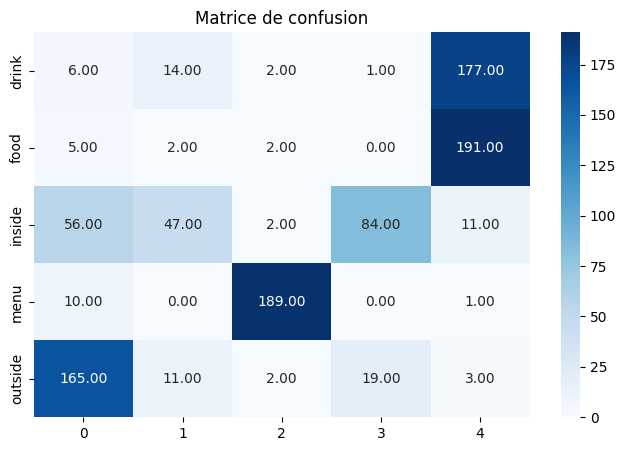

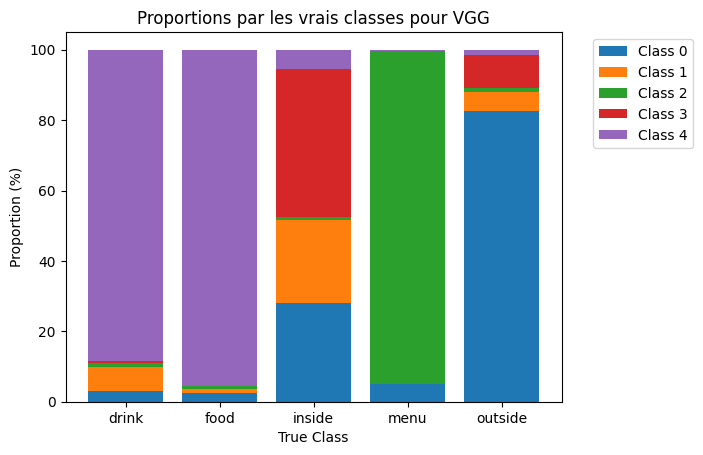

In [10]:
conf_mat_vgg = confusion(labels_encoded, kmeans.labels_)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_mat_vgg, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plot_stacked_bar(conf_mat_vgg, "VGG")